## Versión 1.0

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from utils import *



---
***Preprocesamiento de datos y análisis de correlación***

---

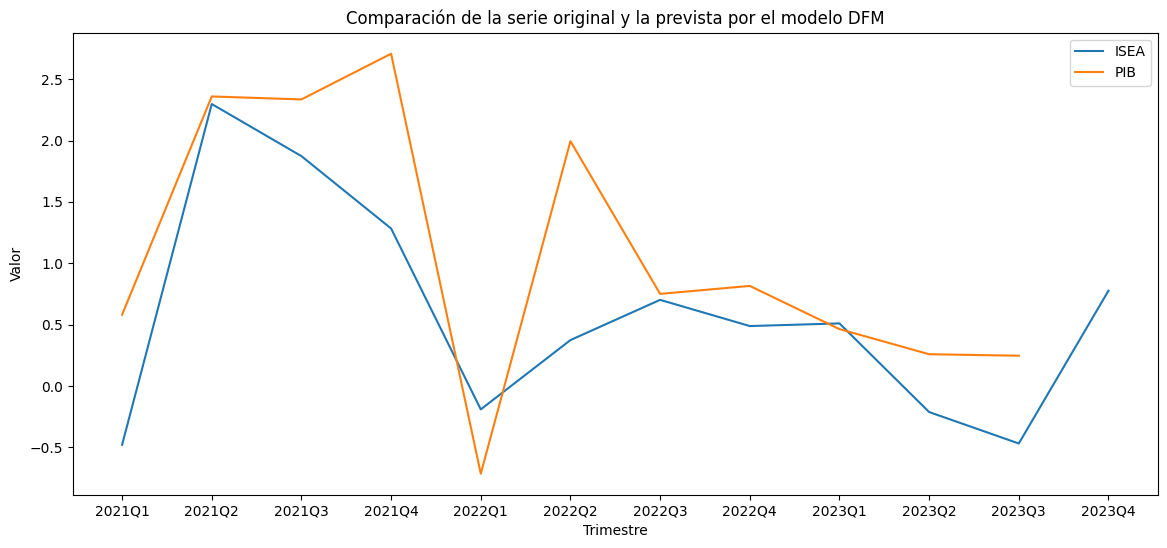

In [15]:

#Importo datos de la excel: los datos fueron suministrados por IECA (04-12-2023)

# Lee el archivo Excel
ruta_archivo = '../Datos/Envío_04_12_2023.xlsx'  # Cambia esto por la ruta de tu archivo Excel


#Series Mensual
nombre_hoja = 'Series_mens_vol_y_desest'  # nombre de la hoja en el archivo Excel
mensual = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja)
# Convierte la columna de fechas al formato deseado (mm-yy)
mensual['fecha'] = pd.to_datetime(mensual['fecha']).dt.strftime('%m-%y')
# Establece la columna 'fecha' como el índice del DataFrame
mensual.set_index('fecha', inplace=True)

#Media movil trimestral
mensual = mensual.rolling(window=3).mean()
mensual = mensual[2:]

#Trimestral

#Mensual
nombre_hoja = 'Serie trim_vol_desest_Índice'  # nombre de la hoja en el archivo Excel
trimestral = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja)
# Convierte la columna de fechas al formato deseado (mm-yy)
trimestral['fecha'] = pd.to_datetime(trimestral['fecha']).dt.strftime('%m-%y')
# Establece la columna 'Fecha' como el índice del DataFrame
trimestral.set_index('fecha', inplace=True)

#Estacionaridad de series 

df_estacionario_mensual, diferencias_por_columna = make_all_stationary_m(mensual)
df_estacionario_trimestral, diferencias_por_columna = make_all_stationary_q(trimestral)

df_estacionario_mensual['Pernoctaciones - Andalucía'] = df_estacionario_mensual['Pernoctaciones - Andalucía'].diff(3)
df_estacionario_mensual['Total afiliados SS Total - Andalucía'] = mensual['Total afiliados SS Total - Andalucía'].diff(3)

endog_m = df_estacionario_mensual
endog_q = df_estacionario_trimestral*100

#Hago merge con datos mensuales "trimestralizados" y el trimestral

# Convertir el índice del DataFrame mensual a formato de fecha y hora
endog_m.index = pd.to_datetime(endog_m.index, format='%m-%y')
# Convertir el índice del DataFrame mensual a formato de fecha y hora
endog_q.index = pd.to_datetime(endog_q.index, format='%m-%y')

endog_q.index = endog_q.index.to_period('Q')
endog_m.index = endog_m.index.to_period('M')

mejores_regresores = ['Importaciones de bienes - Andalucía', 
                        'Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía', 
                        'Total afiliados SS Total - Andalucía', 
                        'Matriculación de turismos - Andalucía', 
                        'Consumo de gasolina y gasóleo', 
                        'Cifra negocios del sector servicios - Andalucía'
                        ]


endog_m_c = endog_m[mejores_regresores].dropna()



endog_q=endog_q[['pib']]
mod = sm.tsa.DynamicFactorMQ(endog_m_c, 
                            endog_quarterly=endog_q, 
                            factor_orders = 2, 
                            factors=2,
                            idiosyncratic_ar1=False)
res = mod.fit()

y_true=endog_q['pib']
y_true=y_true['2002Q1':'2023Q3']

#Hago un get prediction, lo que me extiende el análisis hasta 2023 diciembre

f = res.get_prediction(start='2000-03', end='2023-12')
X_Q = pd.DataFrame(f.prediction_results.filtered_state).T

X_Q = X_Q[[0,5]]

# Obtener el número de filas en el DataFrame
num_filas = X_Q.shape[0]

# Generar un rango de fechas mensuales desde marzo de 2000 con el mismo número de filas que el DataFrame
fechas = pd.date_range(start='2000-03', periods=num_filas, freq='M')

# Asignar las fechas como índice del DataFrame, formateadas como "año-mes"
X_Q.index = fechas.strftime('%Y-%m')
X_Q.index = pd.to_datetime(X_Q.index)

X_Q = X_Q.resample('Q').mean().to_period('Q')

#esto lo hhacía antes
# X_Q = res.factors.filtered.resample('Q').mean().loc['2002Q1':'2023Q3']

# Obtener los índices de los trimestres en común entre y_true y X_Q
indices_comunes = y_true.index.intersection(X_Q.index)


# Filtrar y_true y X_Q para incluir solo los trimestres en común
X_Q_comun = X_Q.loc[indices_comunes]

# Realizar la regresión lineal para los trimestres en común
modelo = sm.OLS(y_true, X_Q_comun).fit()

coeficientes_factores = modelo.params.values

# Convertir el índice a una cadena de texto en formato trimestral
y_true.index = y_true.index.to_timestamp().to_period('Q').strftime('%YQ%q')

# Obtener la predicción del modelo
y_pred = modelo.predict(X_Q)


# Filtrar y_true y y_pred para incluir solo datos a partir de 2021Q1
y_true = y_true['2021Q1':]
y_pred = y_pred[y_pred.index >= '2021Q1']
# Convertir el índice de y_pred de PeriodIndex a Index
y_pred.index = y_pred.index.to_timestamp().to_period('Q').strftime('%YQ%q')

# Graficar y_true y y_pred en el mismo gráfico
plt.figure(figsize=(14, 6))

plt.plot(y_pred.index, y_pred.values, label='y_pred')
plt.plot(y_true.index, y_true.values, label='y_true')
plt.xlabel('Trimestre')
plt.ylabel('Valor')
plt.title('Comparación de la serie original y la prevista por el modelo DFM')

# Introducir nombres manualmente en la leyenda
plt.legend(labels=['ISEA', 'PIB'])  # Fondo negro, borde blanco, texto blanco
plt.show()


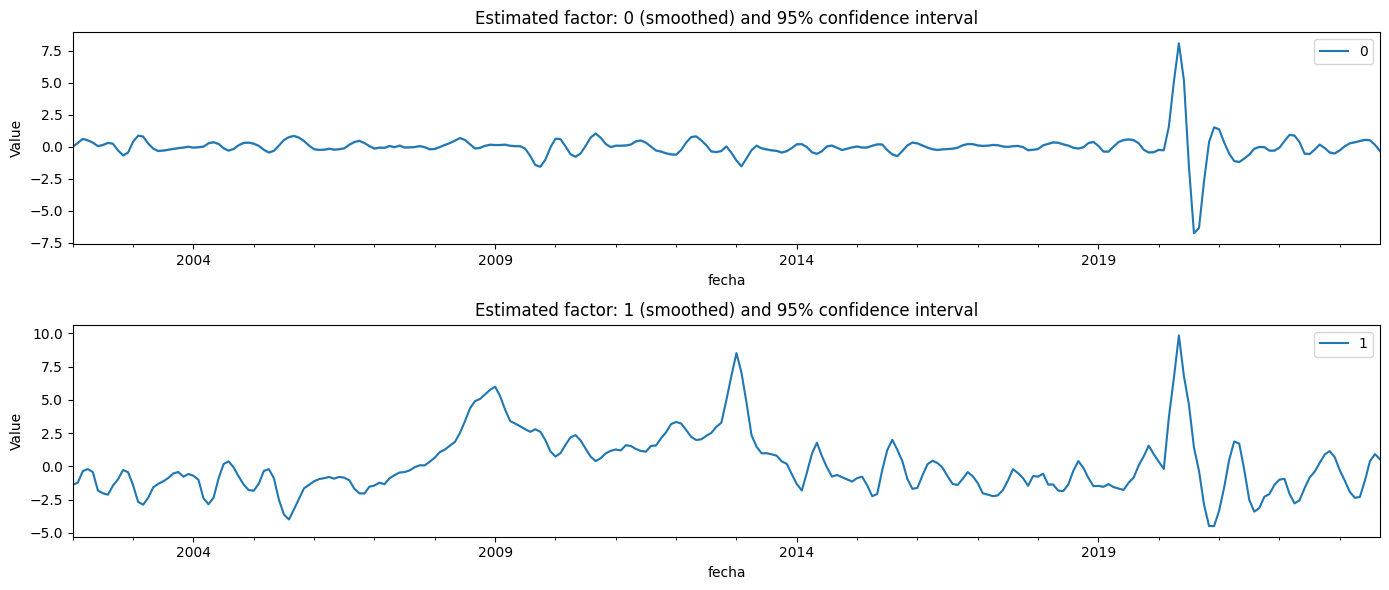

In [16]:
# Get estimates of the global and labor market factors,
# conditional on the full dataset ("smoothed")
factor_names = ['0','1']
mean = res.factors.smoothed[factor_names]


# Compute 95% confidence intervals
from scipy.stats import norm
std = pd.concat([res.factors.smoothed_cov.loc[name, name]
                 for name in factor_names], axis=1)
crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std


# Filtra los datos hasta diciembre de 2019
first_date = '2002-01-01'
mean_l = mean.loc[first_date:]
lower = lower.loc[first_date:]
upper = upper.loc[first_date:]

# Crea ejes diferentes para cada serie
fig, axes = plt.subplots(nrows=len(factor_names), ncols=1, figsize=(14, 3*len(factor_names)))

for i, name in enumerate(factor_names):
    ax = axes[i]
    mean_l[name].plot(ax=ax, label=name)
    ax.fill_between(mean_l.index, lower[name], upper[name], alpha=0.3)
    ax.set(title=f'Estimated factor: {name} (smoothed) and 95% confidence interval')
    ax.set_ylabel('Value')
    ax.legend()

# Ajusta el espaciado entre los subplots
plt.tight_layout()
plt.show()

NOWCASTING

In [17]:
#TRATAMIENTO ANTERIOR FICHERO

#Importo datos de la excel: los datos fueron suministrados por IECA (04-12-2023)

# Lee el archivo Excel
ruta_archivo = '../Datos/Envío_04_12_2023copia.xlsx'  # Cambia esto por la ruta de tu archivo Excel


#Series Mensual
nombre_hoja = 'Series_mens_vol_y_desest'  # nombre de la hoja en el archivo Excel
mensual = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja)
# Convierte la columna de fechas al formato deseado (mm-yy)
mensual['fecha'] = pd.to_datetime(mensual['fecha']).dt.strftime('%m-%y')
# Establece la columna 'fecha' como el índice del DataFrame
mensual.set_index('fecha', inplace=True)

#Media movil trimestral
mensual = mensual.rolling(window=3).mean()
mensual = mensual[2:]

#Trimestral

#Mensual
nombre_hoja = 'Serie trim_vol_desest_Índice'  # nombre de la hoja en el archivo Excel
trimestral = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja)
# Convierte la columna de fechas al formato deseado (mm-yy)
trimestral['fecha'] = pd.to_datetime(trimestral['fecha']).dt.strftime('%m-%y')
# Establece la columna 'Fecha' como el índice del DataFrame
trimestral.set_index('fecha', inplace=True)

#Estacionaridad de series 

df_estacionario_mensual, diferencias_por_columna = make_all_stationary_m(mensual)


df_estacionario_trimestral, diferencias_por_columna = make_all_stationary_q(trimestral)

df_estacionario_mensual['Pernoctaciones - Andalucía'] = df_estacionario_mensual['Pernoctaciones - Andalucía'].diff(3)
df_estacionario_mensual['Total afiliados SS Total - Andalucía'] = mensual['Total afiliados SS Total - Andalucía'].diff(3)

endog_m = df_estacionario_mensual
endog_q = df_estacionario_trimestral*100

#Hago merge con datos mensuales "trimestralizados" y el trimestral

# Convertir el índice del DataFrame mensual a formato de fecha y hora
endog_m.index = pd.to_datetime(endog_m.index, format='%m-%y')
# Convertir el índice del DataFrame mensual a formato de fecha y hora
endog_q.index = pd.to_datetime(endog_q.index, format='%m-%y')

endog_q.index = endog_q.index.to_period('Q')
endog_m.index = endog_m.index.to_period('M')

mejores_regresores = ['Importaciones de bienes - Andalucía', 
                        'Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía', 
                        'Total afiliados SS Total - Andalucía', 
                        'Matriculación de turismos - Andalucía', 
                        'Consumo de gasolina y gasóleo', 
                        'Cifra negocios del sector servicios - Andalucía'
                        ]


endog_m_c2 = endog_m[mejores_regresores].dropna()


# Número de filas desde el final que deseas cambiar a NaN
num_filas_desde_el_final = 1

# Obtener el número total de filas en el DataFrame
num_total_filas = endog_m_c2.shape[0]

# Calcular el rango de filas que deseas cambiar a NaN
rango_filas = slice(num_total_filas - num_filas_desde_el_final, num_total_filas)

endog_m_c2.loc[rango_filas, ['Consumo de gasolina y gasóleo']] = np.nan


endog_q2=endog_q[['pib']]

mod = sm.tsa.DynamicFactorMQ(endog_m_c2, 
                            endog_quarterly=endog_q2, 
                            factor_orders = 2, 
                            factors=2,
                            idiosyncratic_ar1=False)
res_ant = mod.fit()

In [18]:
vintage_ant = res_ant.apply(endog_m_c2, endog_quarterly=endog_q2, 
                    retain_standardization=False)
vintage_post = res_ant.apply(endog_m_c, endog_quarterly=endog_q2, 
                    retain_standardization=False)

In [19]:
news_results=vintage_post.news(
vintage_ant,
impact_date='2023-12',
impacted_variable='pib',
comparison_type='previous')

news_results.details_by_impact

,,,,observed,forecast (prev),news,weight,impact
impact date,impacted variable,update date,updated variable,,,,,
2023-12,pib,2023-09,Consumo de gasolina y gasóleo,-0.004469,0.019857,-0.024327,10.68385,-0.259903
